In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb


In [2]:
df = pd.read_csv('historical_data.csv')

In [3]:
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

Making all datetime in the right format

In [4]:
df["created_at"] = pd.to_datetime(df["created_at"])
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"])
df["actual_total_delivery_time"] = (df["actual_delivery_time"] - df["created_at"]).dt.total_seconds()

In [5]:
df[df["total_busy_dashers"] > df["total_onshift_dashers"]]

# clearly, there are various cases where the no of dasher available in less then the dasher which are busy, meaning there will be chances of pending order

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_time
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,1965.0
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0
18,1.0,2015-01-31 04:35:54,2015-01-31 05:47:30,2841,italian,1.0,2,3150,2,1425,1725,4.0,9.0,12.0,446,548.0,4296.0
20,1.0,2015-01-31 23:45:12,2015-02-01 00:14:05,4139,mexican,1.0,5,1285,3,150,400,12.0,13.0,11.0,446,424.0,1733.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197411,1.0,2015-02-02 17:50:23,2015-02-02 18:12:57,2956,fast,4.0,2,1297,2,369,639,5.0,6.0,7.0,251,186.0,1354.0
197412,1.0,2015-02-10 23:43:08,2015-02-11 00:47:24,2956,fast,4.0,1,674,1,345,345,10.0,11.0,12.0,251,706.0,3856.0
197418,1.0,2015-01-30 20:50:23,2015-01-30 22:24:38,2956,fast,4.0,2,1528,2,639,729,26.0,29.0,34.0,251,791.0,5655.0
197422,1.0,2015-01-31 19:48:15,2015-01-31 20:27:39,2956,fast,4.0,7,2445,3,145,585,23.0,24.0,24.0,251,608.0,2364.0


In [6]:
# adding new feature estimated_non_prep_duration and busy_dasher_ratio 
df['estimated_non_prep_duration'] = df["estimated_store_to_consumer_driving_duration"] + df["estimated_order_place_duration"]
df['busy_dasher_ratio'] = df["total_busy_dashers"] / df["total_onshift_dashers"]

In [7]:
# store all the unique ids of the stores
store_id_unique = df["store_id"].unique().tolist()
store_id_and_category = {store_id: df[df.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}

In [ ]:
# filling all the empty store category, if their store id available in some other column
def fill(store_id):
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
    
df["store_primary_category_nan"] = df.store_id.apply(fill)

In [10]:
order_protocol_dummies = pd.get_dummies(df.order_protocol).astype(int)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies


,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
197423,0,0,0,1,0,0,0
197424,0,0,0,1,0,0,0
197425,0,0,0,1,0,0,0
197426,1,0,0,0,0,0,0


In [11]:
market_id_dummies = pd.get_dummies(df.market_id).astype(int)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [12]:
store_primary_category_dummies = pd.get_dummies(df.store_primary_category_nan).astype(int)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# droping less relevant features
df = df.drop(columns=["market_id", "store_id", "store_primary_category", "store_primary_category_nan", "order_protocol", "created_at", "actual_delivery_time"])
train_df = pd.concat([df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)

In [14]:
np.where(np.any(~np.isfinite(train_df), axis=0) == True)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


(array([ 5,  6,  7,  9, 10, 11, 12], dtype=int64),)

In [15]:
null_count = train_df.isna().sum()
print(null_count[null_count > 0])

total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_store_to_consumer_driving_duration      526
actual_total_delivery_time                          7
estimated_non_prep_duration                       526
busy_dasher_ratio                               19838
dtype: int64


In [16]:
train_df.dropna(inplace=True)
train_df.shape

(177109, 100)

<Axes: >

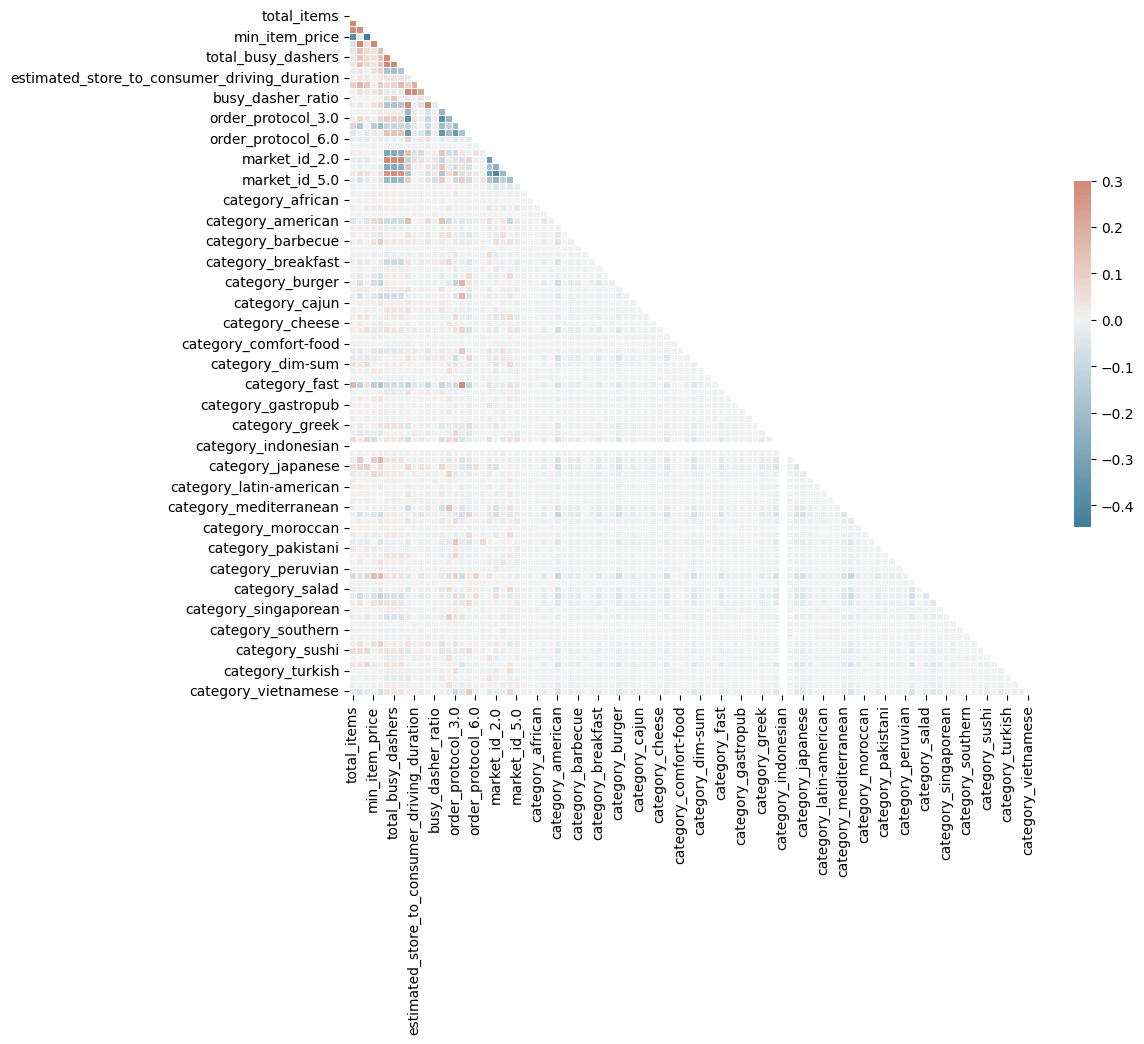

In [17]:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
# as we can see heatmap reveal no important features, and there are high correlation between various variable so we will clean this further. 

In [18]:
def get_redundant_pair(df):
    pair_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i + 1):
            pair_to_drop.add((cols[i], cols[j]))
    return pair_to_drop


In [19]:
def get_top_abs_correlation(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pair(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


In [20]:
# we can drop columns with high similarity like total_onshift_dashers                                       
get_top_abs_correlation(train_df, 20)

total_onshift_dashers                         total_busy_dashers             0.941756
                                              total_outstanding_orders       0.934651
total_busy_dashers                            total_outstanding_orders       0.931306
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923084
estimated_order_place_duration                order_protocol_1.0             0.897620
total_items                                   num_distinct_items             0.758111
subtotal                                      num_distinct_items             0.682854
total_items                                   subtotal                       0.557141
min_item_price                                max_item_price                 0.541274
subtotal                                      max_item_price                 0.507979
order_protocol_4.0                            category_fast                  0.489904
num_distinct_items                            min_item

In [21]:
# removing the market_protocol dummy variables
train_df = pd.concat([df, order_protocol_dummies, store_primary_category_dummies], axis=1)
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers", "category_indonesian"])
train_df = train_df.astype("float32")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_time,estimated_non_prep_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,1307.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,1136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,1136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,735.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1096.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
get_top_abs_correlation(train_df, 20)

estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items                            min_item_price                 0.446733
total_items                                   min_item_price                 0.389277
order_protocol_1.0                            order_protocol_3.0             0.373581
estimated_order_place_duration                order_pr

In [23]:
# dropping order protocals too as it does not reveal any important information
train_df = pd.concat([df, store_primary_category_dummies], axis=1)
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers", "category_indonesian"])
train_df = train_df.astype("float32")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_time,estimated_non_prep_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,1307.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,1136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,1136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,735.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1096.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
get_top_abs_correlation(train_df, 20)

estimated_store_to_consumer_driving_duration  estimated_non_prep_duration       0.923086
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_order_place_duration                estimated_non_prep_duration       0.363297
actual_total_delivery_time                    estimated_non_prep_duration       0.206918
estimated_store_to_consumer_driving_duration  actual_total_delivery_time        0.188418
subtotal             

In [25]:
# feature engineering
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df["percentage_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["subtotal", "max_item_price", "min_item_price", "num_distinct_items", "estimated_non_prep_duration"], inplace=True)
print(get_top_abs_correlation(train_df, 20))


total_items                                   percentage_distinct_item_of_total    0.445751
                                              price_range_of_items                 0.333304
                                              avg_price_per_item                   0.310759
avg_price_per_item                            percentage_distinct_item_of_total    0.226711
category_pizza                                avg_price_per_item                   0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_time           0.188418
category_fast                                 avg_price_per_item                   0.175950
total_outstanding_orders                      estimated_order_place_duration       0.171049
total_items                                   category_fast                        0.170988
category_italian                              avg_price_per_item                   0.158193
total_outstanding_orders                      actual_total_delivery_time        

In [ ]:
def compute_vif(features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)


In [ ]:
features = train_df.drop(columns=["actual_total_delivery_time"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000498
2,category_belgian,1.000760
3,category_russian,1.003231
4,category_african,1.003823
...,...,...
76,busy_dasher_ratio,6.369601
77,category_american,7.033604
78,estimated_store_to_consumer_driving_duration,7.210845
79,estimated_order_place_duration,13.472280


In [26]:
# we prefer column with low VIF so we we will drop column with high VIF value, which means it is highly collinear
train_df.drop(columns=["percentage_distinct_item_of_total"], inplace=True)

(array([1.77062e+05, 7.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.01000000e+02, 3.33391016e+04, 6.65772031e+04, 9.98152969e+04,
        1.33053406e+05, 1.66291500e+05, 1.99529594e+05, 2.32767703e+05,
        2.66005812e+05, 2.99243906e+05, 3.32482000e+05]),
 <BarContainer object of 10 artists>)

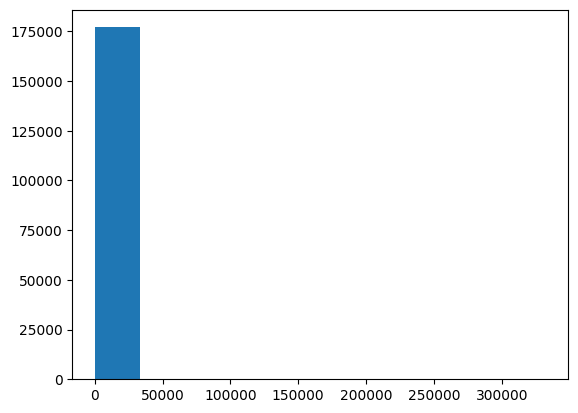

In [27]:
y = train_df["actual_total_delivery_time"]
y = y.astype("float32")
plt.hist(y)

In [ ]:
# there are some outlier in delivery time that's skewing the whole distribution so we will take only 99 quantile of data
threshold = train_df["actual_total_delivery_time"].quantile(0.99)
train_df_trimmed = train_df[train_df["actual_total_delivery_time"] <= threshold].copy()

(array([   67.,  5360., 31299., 50234., 41010., 24150., 12600.,  6149.,
         3028.,  1403.]),
 array([ 101. ,  734.5, 1368. , 2001.5, 2635. , 3268.5, 3902. , 4535.5,
        5169. , 5802.5, 6436. ]),
 <BarContainer object of 10 artists>)

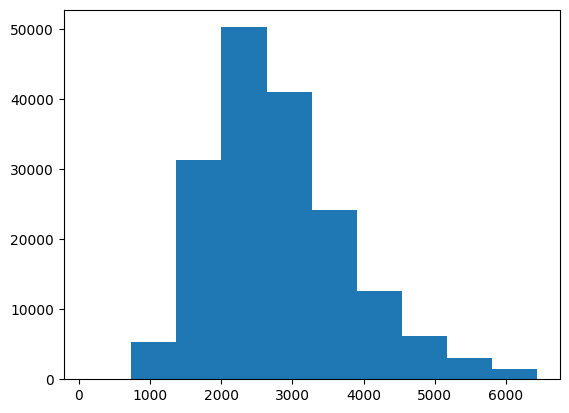

In [30]:
X = train_df_trimmed.drop(columns=["actual_total_delivery_time"])
y = train_df_trimmed["actual_total_delivery_time"]
for c in X.columns:
    if X[c].dtype.kind in "ifb":
        X[c] = X[c].astype("float32")
y = y.astype("float32")
plt.hist(y)

In [31]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, random_state=42)
X_hold_small = X_hold.sample(min(2000, len(X_hold)), random_state=42)
y_hold_small = y_hold.loc[X_hold_small.index]

model = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.08,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",     
    n_jobs=-1
)


Top features by mean(|SHAP|):
estimated_store_to_consumer_driving_duration    205.829407
total_outstanding_orders                        185.455780
busy_dasher_ratio                               168.965881
total_items                                     123.148781
estimated_order_place_duration                  109.607307
avg_price_per_item                               89.002846
price_range_of_items                             30.922092
category_pizza                                   19.890476
category_mexican                                 19.686918
category_japanese                                 8.627436
category_salad                                    7.050938
category_vietnamese                               6.826714
category_dessert                                  6.749684
category_sandwich                                 5.776999
category_indian                                   5.401180
category_breakfast                                5.239666
category_burger          

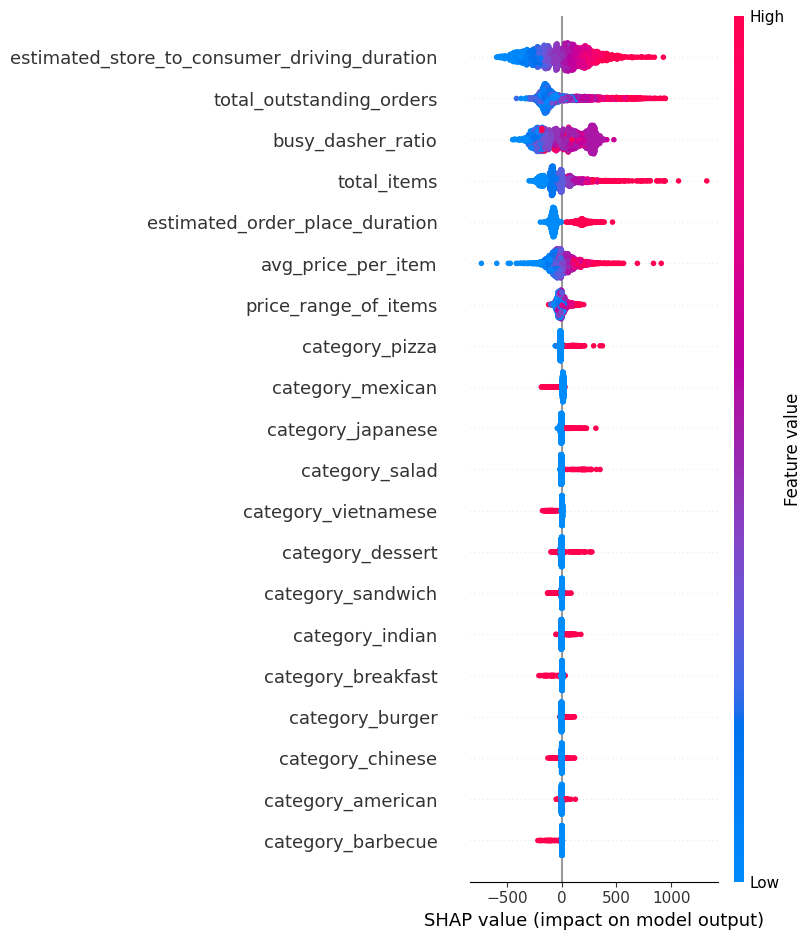

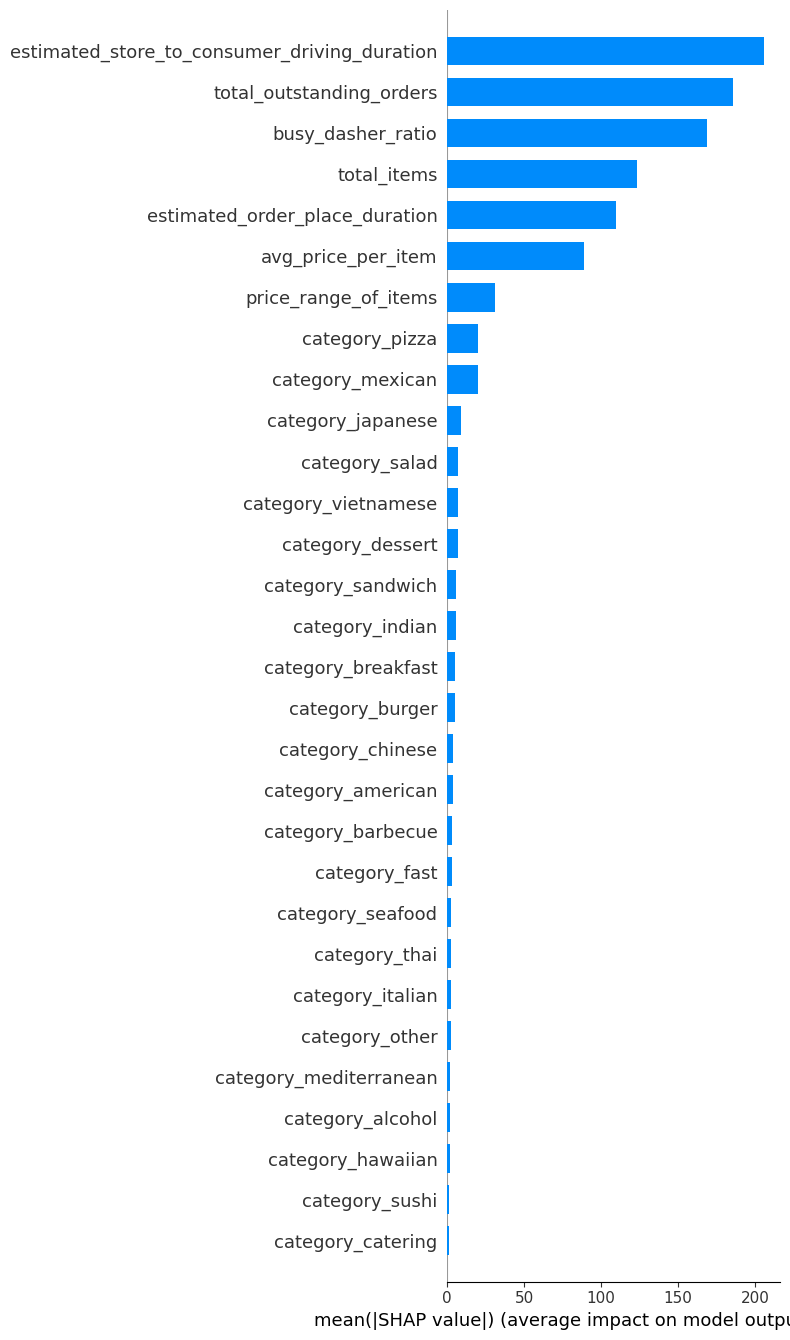

In [32]:
model.fit(X_train, y_train, eval_set=[(X_hold_small, y_hold_small)], verbose=False)

dm = xgb.DMatrix(X_hold_small)
shap_values = model.get_booster().predict(dm, pred_contribs=True)
shap_values = shap_values[:, :-1]   

# Global importance from mean(|SHAP|)  
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X_hold_small.columns).sort_values(ascending=False)
print("\nTop features by mean(|SHAP|):")
print(shap_importance.head(30))

#  Plots 
# Beeswarm: shows direction & spread per feature (sampled holdout)
shap.summary_plot(shap_values, X_hold_small)                 
# Bar plot: clean global ranking
shap.summary_plot(shap_values, X_hold_small, plot_type="bar", max_display=30)

In [ ]:
# feature engineering part 3 duration_per_item help model to detect longer prep times for larger amount of items
# prep_to_drive ratio helps capturing which is slower the prep time or the drive duration

train_df["demand_pressure"] = train_df["busy_dasher_ratio"] * train_df["total_outstanding_orders"]
train_df["prep_to_drive_ratio"] = train_df["estimated_order_place_duration"] / train_df["estimated_store_to_consumer_driving_duration"]
train_df["duration_per_item"] = train_df["estimated_order_place_duration"] / train_df["total_items"]

In [34]:
# only keeping the categories that are good measure
keep_categories = [
    "category_pizza",
    "category_mexican",
    "category_japanese",
    "category_indian",
    "category_fast",
    "category_american",
    "category_burger",
    "category_salad",
    "category_breakfast"
]

all_category_cols = [c for c in train_df.columns if c.startswith("category_")]
drop_categories = [c for c in all_category_cols if c not in keep_categories]

train_df_reduced = train_df.drop(columns=drop_categories)

In [35]:
X_new = train_df_reduced.drop(columns=["actual_total_delivery_time"])
Y_new = train_df_reduced["actual_total_delivery_time"]
for c in X_new.columns:
    if X_new[c].dtype.kind in "ifb":
        X_new[c] = X_new[c].astype("float32")
y_new = Y_new.astype("float32")

In [36]:
X_train, X_hold, y_train, y_hold = train_test_split(X_new, y_new, test_size=0.2, random_state=42)
X_hold_small = X_hold.sample(min(2000, len(X_hold)), random_state=42)
y_hold_small = y_hold.loc[X_hold_small.index]

model = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.08,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",     
    n_jobs=-1
)

In [37]:
mask = np.isfinite(X_train).all(axis=1)
X_train = X_train[mask]
y_train = y_train[mask]

In [38]:
mask = np.isfinite(X_hold).all(axis=1)
X_hold = X_hold[mask]
y_hold = y_hold[mask]


Top features by mean(|SHAP|):
estimated_store_to_consumer_driving_duration    203.053696
busy_dasher_ratio                               173.551743
total_outstanding_orders                        129.984604
estimated_order_place_duration                  124.289230
total_items                                     103.111572
demand_pressure                                 100.479370
avg_price_per_item                               97.644279
price_range_of_items                             43.592407
prep_to_drive_ratio                              34.621925
category_pizza                                   28.867970
category_mexican                                 19.419884
duration_per_item                                18.937462
category_japanese                                13.712133
category_burger                                  10.189142
category_indian                                  10.148078
category_salad                                    7.361052
category_breakfast       

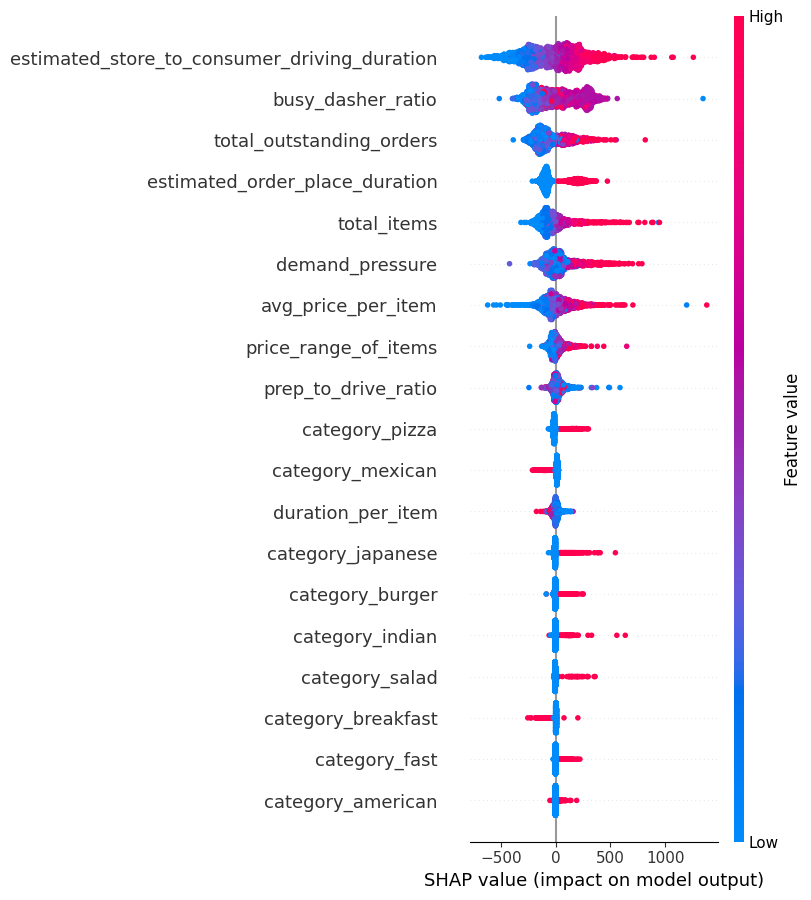

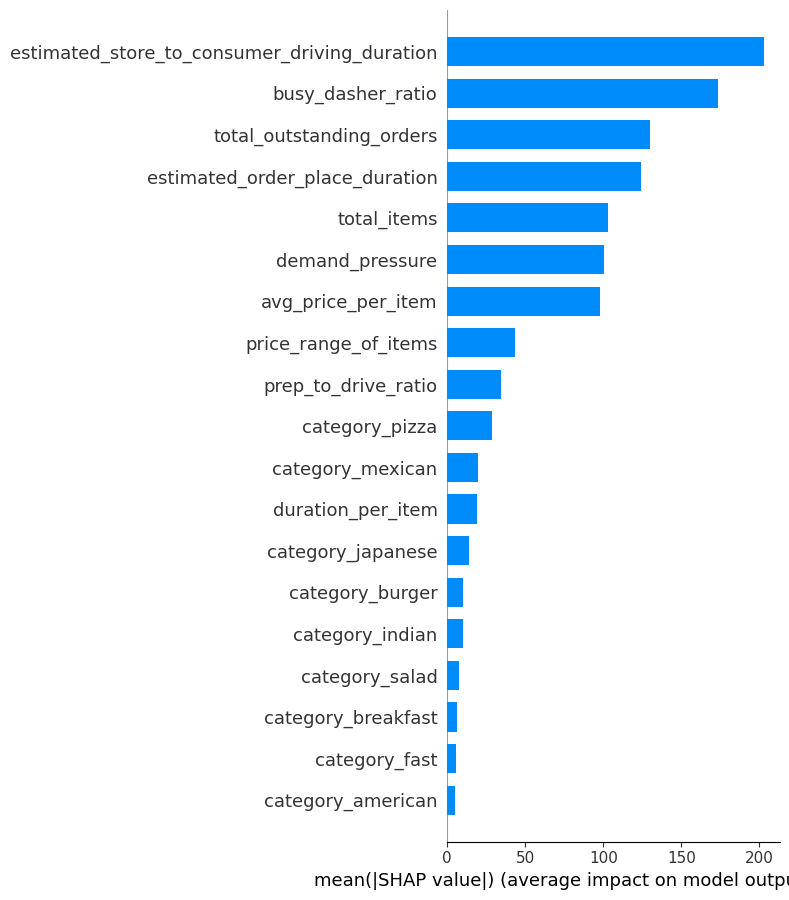

In [ ]:
model.fit(X_train, y_train, eval_set=[(X_hold_small, y_hold_small)], verbose=False)

dm = xgb.DMatrix(X_hold_small)
shap_values = model.get_booster().predict(dm, pred_contribs=True)
shap_values = shap_values[:, :-1]   

# Global importance from mean(|SHAP|) 
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X_hold_small.columns).sort_values(ascending=False)
print("\nTop features by mean(|SHAP|):")
print(shap_importance.head(30))

# Plots 
# Beeswarm: shows direction & spread per feature (sampled holdout)
shap.summary_plot(shap_values, X_hold_small)                
# Bar plot: clean global ranking
shap.summary_plot(shap_values, X_hold_small, plot_type="bar", max_display=30)

Training ML model

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_hold_scaled = scaler.fit_transform(X_hold)


In [ ]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_hold_scaled)


mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver="adam", max_iter=300, random_state=42)
mlp.fit(X_train_scaled, y_train)
mlp_predict =  mlp.predict(X_hold_scaled)


lgbm = lgb.LGBMRegressor(n_estimators=800, learning_rate=0.5, subsample=0.8, colsample_bytree=0.8, max_depth=-1, random_state=42)
lgbm.fit(X_train, y_train)
lgbm_predict =  lgbm.predict(X_hold)

xgb_model = xgb.XGBRegressor(n_estimators=800, learning_rate=0.5, max_depth=8, subsample=0.8, colsample_bytree=0.8, objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_hold)


In [56]:
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

rmse_scores = {
    "Ridge" : rmse(y_hold, ridge_pred),
    "MLP": rmse(y_hold, mlp_predict),
    "LightGBM" : rmse(y_hold, lgbm_predict),
    "XGBoost": rmse(y_hold, xgb_pred)
}

print("RMSE Scores:")
for k, v in rmse_scores.items():
    print(f"{k:12s}: {v:.4f}")

RMSE Scores:
Ridge       : 2053.8257
MLP         : 2038.3066
LightGBM    : 2063.6813
XGBoost     : 2128.7306


In [59]:
ensemble_pred = 0.7 * ridge_pred + 0.3 * lgbm_predict
ensemble_rmse = rmse(y_hold, ensemble_pred)

print("\nEnsemble (Ridge 40% + LGBM 60%):", ensemble_rmse)


Ensemble (Ridge 40% + LGBM 60%): 2043.084852533664
